In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.transforms as tf
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2
from PIL import Image

import math
import os
import time
import pathlib
from datetime import datetime
from tqdm.auto import tqdm
import imageio
import IPython
import uuid
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helpers

In [2]:
class Image_Helper:
    @staticmethod
    def load_image(path):
        return cv2.imread(str(path))

class Data_Helper:
    @staticmethod
    def randomly_load_from_directory(directory, n_images_to_load, file_extension='jpg'):
        directory = pathlib.Path(directory)
        image_paths = map(str, list(directory.glob(f"*/*.{file_extension}")))
        random.shuffle(image_paths)

        images = [Image_Helper.load_image((image_path)) for image_path in image_paths[0: n_images_to_load]]
        return images

    @staticmethod
    def gen_metadata_from_directory(data_path, file_extension='jpg'):
        data_path = pathlib.Path(data_path)
        n_classes = len([path for path in data_path.glob("*") if path.is_dir()])

        image_paths = []
        labels = []

        for class_dir in tqdm(data_path.iterdir(), total=n_classes):
            # Check if it's a valid directory
            if not class_dir.is_dir():
                pass

            # Add the images to the dataframe
            for image_path in class_dir.glob(f"*.{file_extension}"):
                image_paths.append(image_path)
                labels.append(class_dir.name)

        # Create the dataframe
        data_frame =  pd.DataFrame({"image_paths": image_paths, "labels": labels})

        # Shuffle the dataframe
        data_frame = data_frame.sample(frac=1).reset_index(drop=True)

        return data_frame, n_classes

    @staticmethod
    def plot(images, titles=None, figSize=(10, 10), isBGR=True, nCols=7):
        """
        This method allows you to display a collection of images in a grid, with titles for each image.

        Parameters:
        - `images` (list): A list of images.
        - `titles` (list, optional): A list of strings, representing the title for each image. The length of `titles` should be equal to the length of `images`.
        - `figSize` (tuple): The size of the figure.
        - `isBGR` (bool, optional): Indicates whether the input images are in BGR format (default is True).
        - `nCols` (int, optional): The number of columns in the grid (default is 3).

        Returns:
        None
        """

        # Check if the images and the titles have the same length
        if titles is not None and len(images) != len(titles):
            raise ValueError("Images and titles must have the same length")

        # Calculate the number of rows required for the figure
        nRows = int(np.ceil(len(images) / nCols))

        # Create the fig
        fig, axes = plt.subplots(nrows=nRows, ncols=nCols, figsize=figSize)

        for ax, img, title in itertools.zip_longest(axes.flat, images, titles or []):
            if isBGR:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ax.imshow(img)
            if titles is not None:
                ax.set_title(title)

            # Remove the tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        fig.tight_layout()

# Read Dataset with Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = '/content/drive/MyDrive/Colab Notebooks/dataset/real'
os.listdir(data_path)

['human']

# Hyperparameters
All the Hyperparameters are based on https://arxiv.org/abs/1511.06434

In [5]:
batch_size = 128
epochs = 200
# epochs = 500

weights_init_mean = 0.0
weights_init_stddev = 0.02

generator_lr = 2e-4
discriminator_lr = 2e-4
beta1 = 0.5
beta2 = 0.999

feature_scale = 64
n_image_channels = 3
image_size = 64
latent_dim = 100
log_interval = 30

log_dir = r"./logs"
save_dir = r"./models"

model_name = f"Human_Generator - {datetime.now().strftime('%Y%m%d-%H%M%S')}"

# Loading the Dataset

In [6]:
# Preprocessing
transforms = torchvision.transforms.transforms.Compose(
    [
        tf.Resize((image_size, image_size)),
        tf.ToTensor(),
        # Noramlize the pixels between [-1, 1]
        tf.Normalize([0.5 for channel in range(n_image_channels)],
                     [0.5 for channel in range(n_image_channels)])
    ]
)

# Load the dataset
#dataset = torchvision.datasets.MNIST(root="MNIST/", train=True, transform=transforms, download=True)      # For testing
dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transforms)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Data Analysis

In [7]:
meta_data, n_classes = Data_Helper.gen_metadata_from_directory(data_path)

  0%|          | 0/1 [00:00<?, ?it/s]

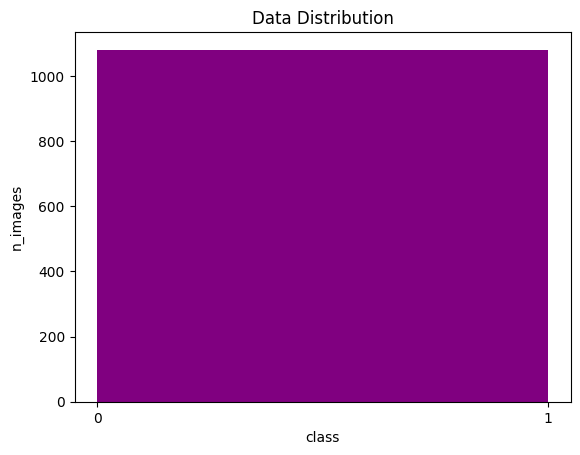

In [8]:
# Plot the histogram
plt.hist(meta_data.labels.to_numpy(),
         bins=np.arange(0, n_classes + 1),
         color='purple')
plt.xticks(ticks=np.arange(0, n_classes + 1),
           labels=np.arange(0, n_classes + 1))

# Set the labels
plt.title("Data Distribution")
plt.xlabel("class")
plt.ylabel("n_images")

# Dislpay the plot
plt.show()

In [9]:
print(f"Number of samples in the dataset: {len(meta_data)}")

Number of samples in the dataset: 1081


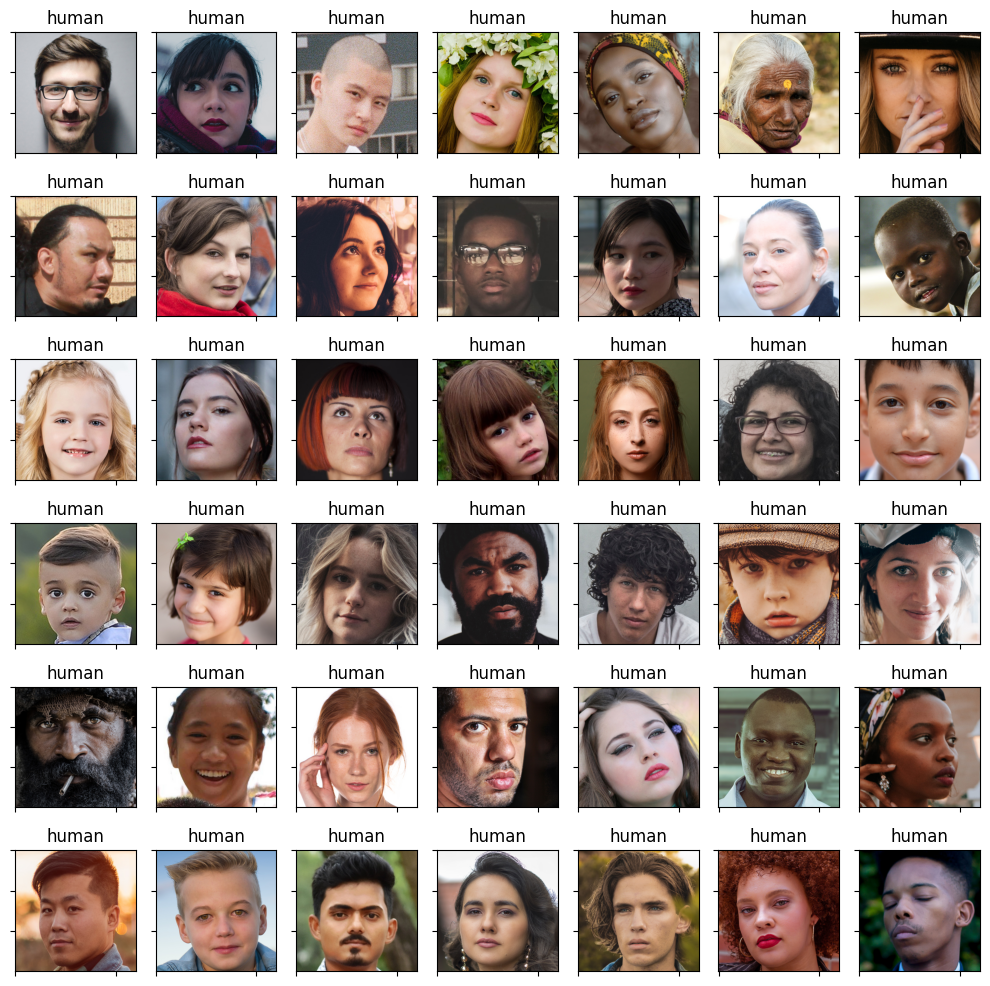

In [10]:
n_images_to_plot = 42

# Shuffle the dataframe
meta_data = meta_data.sample(frac=1).reset_index(drop=True)

# Randomly select images form the dataframe
start_index = random.randint(0, len(meta_data) - n_images_to_plot)

image_paths = meta_data.iloc[start_index: start_index + n_images_to_plot].image_paths.to_list()
labels =  meta_data.iloc[start_index: start_index + n_images_to_plot].labels.to_list()

# Load the images
images = [Image_Helper.load_image(image_path) for image_path in image_paths]

# Plot the images
Data_Helper.plot(images, labels, figSize=(10, 10))

# Creating the Generator & Discriminator
Network Architecture based on https://arxiv.org/abs/1511.06434

In [11]:
# Define the weight initializer
def weights_init(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, weights_init_mean, weights_init_stddev)     # _ means inplace

In [12]:
# Define generator
class Generator(nn.Module):
    def __init__(self, latent_dim, n_image_channels, feature_scale=64):
        assert feature_scale % 2 == 0
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            # 1 x 1 => 4 x 4
            nn.ConvTranspose2d(latent_dim, feature_scale * 16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_scale * 16),
            nn.ReLU(),

            # 4 x 4 => 8 x 8
            nn.ConvTranspose2d(feature_scale * 16, feature_scale * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_scale * 8),
            nn.ReLU(),

            # 8 x 8 => 16 x 16
            nn.ConvTranspose2d(feature_scale * 8, feature_scale * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_scale * 4),
            nn.ReLU(),

            # 16 x 16 => 32 x 32
            nn.ConvTranspose2d(feature_scale * 4, feature_scale * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_scale * 2),
            nn.ReLU(),

            # 16 x 16 => 64 x 64
            nn.ConvTranspose2d(feature_scale * 2, n_image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        ).to(device)

    def forward(self, x):
        return self.generator(x)

In [13]:
# Define discriminator
class Discriminator(nn.Module):
    def __init__(self, n_image_channels, feature_scale=64):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            # 64 x 64 => 32 x 32
            nn.Conv2d(n_image_channels, feature_scale * 1, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            # 32 x 32 => 16 x 16
            nn.Conv2d(feature_scale * 1, feature_scale * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_scale * 2),
            nn.LeakyReLU(0.2),

            # 16 x 16 => 8 x 8
            nn.Conv2d(feature_scale * 2, feature_scale * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_scale * 4),
            nn.LeakyReLU(0.2),

            # 8 x 8 => 4 x 4
            nn.Conv2d(feature_scale * 4, feature_scale * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_scale * 8),
            nn.LeakyReLU(0.2),

            # 4 x 4 => 1 x 1
            nn.Conv2d(feature_scale * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        ).to(device)

    def forward(self, x):
        return self.discriminator(x)

In [14]:
# Create the models
generator = Generator(latent_dim, n_image_channels, feature_scale).to(device)
discriminator = Discriminator(n_image_channels, feature_scale).to(device)

# Initialize the parameters
weights_init(generator)
weights_init(discriminator)

# Define the optimizers and loss
gen_opt = optim.Adam(generator.parameters(), lr=generator_lr, betas=(beta1, beta2))
disc_opt = optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=(beta1, beta2))
criterian = nn.BCELoss().to(device)

# Define the Tensorboard writers
fixed_noise = torch.randn((32, latent_dim, 1, 1)).to(device)
writer_real = SummaryWriter(os.path.join(log_dir, model_name, "real"))
writer_fake = SummaryWriter(os.path.join(log_dir, model_name, "fake"))
log_step = 0

# Switch to training mode
print(generator.train())
print(discriminator.train())

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)
Discriminator(
  (discriminator): Sequential(
   

# Train Loop

In [15]:
fake_grids = []

# Training loop
for epoch in tqdm(range(1, epochs + 1), desc="Total epochs", colour='purple'):
    for i , (batch, _) in tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch}"):
        # Generater forward pass
        noise = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
        real_images = batch.to(device)
        fake_images = generator(noise)

        # Discriminator forwardpass
        real_yhat = discriminator(real_images).reshape(-1)
        fake_yhat = discriminator(fake_images.detach()).reshape(-1)

        # Calculate discriminator's loss
        disc_real_loss = criterian(real_yhat, torch.ones_like(real_yhat)).to(device)
        disc_fake_loss = criterian(fake_yhat, torch.zeros_like(fake_yhat)).to(device)
        disc_total_loss = (disc_real_loss + disc_fake_loss)

        # apply the discriminator's gradients
        discriminator.zero_grad()
        disc_total_loss.backward(retain_graph=True)
        disc_opt.step()

        # Calculate generator's los
        yhat = discriminator(fake_images)
        gen_total_loss = criterian(yhat, torch.ones_like(yhat)).to(device)

        # apply the generator's gradients
        generator.zero_grad()
        gen_total_loss.backward()
        gen_opt.step()

        # Logging
        tqdm.write(f"Generator_Loss: {gen_total_loss:.5f} - Discriminator_Loss: {disc_total_loss:.5f}", end='\r')

        if i % log_interval == 0:
            with torch.no_grad():
                # Generate new images
                generated_images = generator(fixed_noise)

                # Create a grid
                real_grid = torchvision.utils.make_grid(batch[:32], normalize=True)
                fake_grid = torchvision.utils.make_grid(generated_images[:32], normalize=True)

                # Append the generated images to a list (for creating a gif)
                fake_grid_converted = fake_grid.cpu().permute(1, 2, 0)                         # First we have to move the image to CPU and reshape it
                fake_grid_converted = np.array(fake_grid_converted * 255.0, dtype=np.uint8)
                fake_grids.append(fake_grid_converted)

                # Log to Tensorboard
                writer_real.add_image("Real", real_grid, global_step=log_step)
                writer_fake.add_image("Fake", fake_grid, global_step=log_step)

                log_step += 1

Total epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 80:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 81:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 85:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 86:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 87:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 88:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 89:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 90:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 91:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 92:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 93:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 94:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 95:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 96:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 97:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 98:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 99:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 101:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 102:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 103:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 104:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 105:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 106:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 107:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 108:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 109:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 110:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 111:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 112:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 113:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 114:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 115:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 116:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 117:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 118:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 119:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 120:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 121:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 122:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 123:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 124:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 125:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 126:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 127:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 128:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 129:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 130:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 131:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 132:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 133:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 134:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 135:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 136:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 137:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 138:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 139:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 140:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 141:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 142:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 143:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 144:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 145:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 146:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 147:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 148:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 149:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 151:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 152:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 153:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 154:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 155:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 156:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 157:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 158:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 159:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 160:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 161:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 162:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 163:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 164:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 165:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 166:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 167:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 168:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 169:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 170:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 171:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 172:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 173:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 174:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 175:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 176:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 177:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 178:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 179:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 180:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 181:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 182:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 183:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 184:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 185:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 186:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 187:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 188:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 189:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 190:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 191:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 192:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 193:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 194:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 195:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 196:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 197:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 198:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 199:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 200:   0%|          | 0/9 [00:00<?, ?it/s]

In [21]:
# Save the model
torch.save(generator, os.path.join(save_dir, f"{model_name}.pt"))

# Model Evaluation

In [17]:
generator = torch.load(os.path.join(save_dir, f"{model_name}.pt"))

In [18]:
# Create and display a gif
gif_dir = os.path.join(log_dir, f"{model_name} -- {str(uuid.uuid4())}.gif")

# Create the gif
imageio.mimsave(gif_dir, fake_grids, fps=50)

# Display the gif
IPython.display.Image(filename=gif_dir)

In [19]:
def generate_grid(n_images=1024, nrow=None, save=True, save_dir="./logs/images"):
    if nrow is None:
        nrow = int(math.sqrt(n_images))

    # Generator forward pass
    noise = torch.randn(n_images, latent_dim, 1, 1)
    generator.to(torch.device('cpu'))
    generated_images = generator(noise)

    # Create a grid
    grid = torchvision.utils.make_grid(generated_images, normalize=True, nrow=nrow)

    # Reshape the grid
    grid = grid.permute(1, 2, 0)

    # Convert to np array
    grid = grid.numpy()

    # Scale pixel values from [0,1] to [0,255] and convert to uint8
    grid = (grid * 255).astype('uint8')

    # Create a PIL image from the numpy array
    img = Image.fromarray(grid)

    # Save the image as a JPEG
    if save:
        img.save(os.path.join(save_dir, f"generated_humans -- {str(uuid.uuid4())}.jpg"),
                 format='JPEG')

    return grid

In [ ]:
# Generate a 32 by 32 grid
grid = generate_grid(n_images=32 * 32)

# Plot the grid
fig = plt.figure(figsize=(100, 100))
plt.imshow(grid)
plt.show()